# Whisper Probability Trace Analysis
This notebook demonstrates how to extract and visualize the "Probability Trace" of a target word from the OpenAI Whisper model.

The procedure involves:
1. Loading the Whisper model.
2. Forcing the model to align a specific target word (or competitor) to the audio.
3. Extracting the **Cross-Attention** weights from the valid decoder steps.
4. Weighting the attention by the predicted **Token Probabilities**.
5. Computing a time-series "Trace" that approximates when the word is being spoken and with what confidence.


In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torchaudio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from tqdm import tqdm

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

2026-02-19 00:46:53.022423: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using device: cuda


In [11]:
# Load Model with Hugging Face Transformers
# Using "openai/whisper-base" to match previous size
model_name = "openai/whisper-base"
print(f"Loading {model_name}...")

processor = WhisperProcessor.from_pretrained(model_name)
# Force eager attention implementation to support output_attentions=True
# NOTE: "sdpa" or "flash_attention_2" often do not support returning attention weights.
model = WhisperForConditionalGeneration.from_pretrained(model_name, attn_implementation="eager").to(device)
model.eval()

print("Model loaded.")

Loading openai/whisper-base...
Model loaded.


In [54]:
def get_whisper_probability_trace(audio_path, target_word, processor, model, waveform_len_sec):
    """
    Computes a time-varying probability trace using Whisper's cross-attention weights.
    
    Returns:
        trace (np.array): The probability trace over time (aligned to audio frames).
        token_probs (list): Probabilities of each token in the target word.
        tokens (list): The actual tokens of the target word.
        duration (float): Duration of the audio in seconds.
        sampling_rate (int): Effective sampling rate of the trace (50Hz for Whisper).
    """
    
    # 1. Load and Process Audio
    waveform, sample_rate = torchaudio.load(audio_path)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    
    # Convert to mono and numpy
    waveform = waveform.squeeze()
    if waveform.ndim > 1:
        waveform = waveform.mean(dim=0) 
    # Add 200 ms padding in the left
    # Pad with 200ms silence (optional, as in your script)
    silence = torch.zeros(int(0.2 * 16000))
    waveform = torch.cat([silence, waveform], dim=0)

    
    audio_np = waveform.numpy()
    
    duration = len(audio_np) / 16000.0
    
    # Processor expects raw audio input
    inputs = processor(audio_np, sampling_rate=16000, return_tensors="pt")
    input_features = inputs.input_features.to(device)

    # 2. Prepare Decoder Input for Forced Alignment
    # We want to force the model to predict the target word.
    
    # Add leading space if not present (Whisper convention)
    # Also Capitalize as it often matches start-of-sentence behavior better
    target_text = " " + target_word.strip()
    if not target_text[1].isupper():
         target_text = " " + target_word.strip().capitalize()
    
    # Helper to get forced decoder ids
    # Try different methods for compatibility
    try:
        forced_decoder_ids = processor.get_decoder_prompt_ids(language="en", task="transcribe", no_timestamps=True)
    except AttributeError:
        # Fallback manual construction if method missing
        forced_decoder_ids = [
            (1, processor.tokenizer.convert_tokens_to_ids("<|en|>")),
            (2, processor.tokenizer.convert_tokens_to_ids("<|transcribe|>")),
            (3, processor.tokenizer.convert_tokens_to_ids("<|notimestamps|>"))
        ]
    
    # forced_decoder_ids is a list of (index, token_id). We just need the tokens in order.
    # Usually they are sorted by index.
    forced_tokens = [t[1] for t in sorted(forced_decoder_ids, key=lambda x: x[0])]
    
    # Start with SOT
    sot_token = processor.tokenizer.convert_tokens_to_ids("<|startoftranscript|>")
    prefix_tokens = [sot_token] + forced_tokens
        
    # Encode target word
    # add_special_tokens=False to just get the word tokens
    text_tokens = processor.tokenizer.encode(target_text, add_special_tokens=False)
    eot_token = processor.tokenizer.eos_token_id
    
    full_sequence = prefix_tokens + text_tokens + [eot_token]
    decoder_input_ids = torch.tensor([full_sequence], device=device)
    
    # 3. Forward Pass with Attention
    with torch.no_grad():
        outputs = model(
            input_features=input_features,
            decoder_input_ids=decoder_input_ids,
            output_attentions=True,
            return_dict=True
        )
    
    # 4. Calculate Token Probabilities
    logits = outputs.logits # (1, SeqLen, Vocab)
    probs = F.softmax(logits, dim=-1)
    
    # Indices of our target word tokens in the sequence
    start_idx = len(prefix_tokens)
    end_idx = start_idx + len(text_tokens)
    
    token_probs = []
    tokens = []
    
    # Check probabilities for each token in the word
    # The prediction for token at `i` comes from `logits[i-1]`
    print("len of probs:", probs.shape)
    print("decoder_input_ids:", decoder_input_ids)
    for i in range(start_idx, end_idx):
        target_token_id = decoder_input_ids[0, i]
        # Logits at i-1 predict token at i
        p = probs[0, i-1, target_token_id].item()
        
        token_str = processor.tokenizer.convert_ids_to_tokens([target_token_id.item()])[0]
        token_probs.append(p)
        tokens.append(token_str)
        current_token = processor.tokenizer.convert_ids_to_tokens([target_token_id])[0]
        previous_tokens = processor.tokenizer.convert_ids_to_tokens(decoder_input_ids[0, :i+1].tolist()) # +1 for target shift
        
        print("P({}|{}) = {p:.4f}".format(current_token, previous_tokens, p=p))
        
        
    token_probs_tensor = torch.tensor(token_probs, device=device)
    
    # 5. Extract Cross-Attention
    # Layer weights: (Batch, Heads, DecoderSeq, EncoderSeq)
    # Use the last layer
    if outputs.cross_attentions is None:
        raise ValueError("Model must output attentions. Ensure output_attentions=True.")
        
    layer_atten = outputs.cross_attentions[-1] 
    avg_atten = layer_atten.mean(dim=1).squeeze(0) # (DecoderSeq, EncoderSeq)
    
    if waveform_len_sec is not None:
        num_frames = int(waveform_len_sec / 0.02)
        # Ensure we don't go out of bounds if calculation is slightly off
        num_frames = min(num_frames, avg_atten.shape[1])
        avg_atten = avg_atten[:, :num_frames]
    
    # Range of attention indices: start_idx-1 to end_idx-1 (exclusive)
    word_attentions = avg_atten[start_idx-1 : end_idx-1, :]
    
    # 6. Compute Trace
    # Weight attention rows by their token probabilities
    weighted_atts = word_attentions * token_probs_tensor.unsqueeze(1)
    
    # Mean over tokens to get one trace per time step
    # Important: Whisper's cross attention refers to encoder outputs (1500 frames for 30s)
    # It is ALREADY aligned to time (compressed time).
    
    # We average the attention weights of all tokens in the word.
    raw_trace = weighted_atts.mean(dim=0).cpu().numpy()
    
    # Crop to audio duration (Whisper frames are 20ms)
    num_frames = int(duration / 0.02)
    
    # Handle potentially short or long trace
    current_frames = len(raw_trace)
    
    # Whisper pads audio to 30s, so attention is always 1500 length
    # We just need the valid part
    if num_frames <= current_frames:
        trace = raw_trace[:num_frames]
    else:
        # Pad if short (rare, should be covered by 1500)
        trace = np.pad(raw_trace, (0, num_frames - current_frames))
    
    # Scaling
    max_val = trace.max()
    mean_prob = token_probs_tensor.mean().item()
    if max_val > 0:
         trace = trace / max_val * mean_prob
         
    return {
        "trace": trace,
        "raw_attentions": word_attentions.cpu().numpy(),
        "token_probs": token_probs,
        "tokens": tokens,
        "duration": duration,
        "sampling_rate": 50
    }

In [52]:
def load_audio(path):
    """Loads audio and resamples to 16kHz."""
    waveform, sample_rate = torchaudio.load(path)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    return waveform.squeeze()

In [56]:
# Select an Audio File
wav_path = "dataset/en/ainhoa/academy.wav"
target_word = "academy"

print(f"Processing: {wav_path}")
print(f"Target Word: {target_word}")

# Prepare Audio
waveform = load_audio(wav_path)

# Pad with 200ms silence (optional, as in your script)
silence = torch.zeros(int(0.2 * 16000))
waveform = torch.cat([silence, waveform], dim=0)

duration_sec = waveform.shape[0] / 16000
print(f"Audio Duration: {duration_sec:.2f}s")

# Run Analysis
if not os.path.exists(wav_path):
    print(f"Warning: File {wav_path} not found. Please provide a valid path.")
else:
    # Use our new function with Transformers model
    result = get_whisper_probability_trace(wav_path, target_word, processor, model,  duration_sec)

    trace = result["trace"]
    attentions = result["raw_attentions"]
    token_probs = result["token_probs"]
    tokens = result["tokens"]
    duration = result["duration"]
    sampling_rate = result["sampling_rate"]

    print(f"Token Probabilities: {token_probs}")
    print(f"attenion shape: {attentions.shape}")
    print(f"Tokens: {tokens}")
    print(f"Trace Shape: {trace.shape} (Sampling rate {sampling_rate}Hz)")
    print(f"Duration from metadata: {duration:.2f}s")

Processing: dataset/en/ainhoa/academy.wav
Target Word: academy
Audio Duration: 0.90s
len of probs: torch.Size([1, 6, 51865])
decoder_input_ids: tensor([[50258, 50259, 50359, 50363, 11735, 50257]], device='cuda:0')
P(ĠAcademy|['<|startoftranscript|>', '<|en|>', '<|transcribe|>', '<|notimestamps|>', 'ĠAcademy']) = 0.9678
Token Probabilities: [0.9678492546081543]
attenion shape: (1, 44)
Tokens: ['ĠAcademy']
Trace Shape: (44,) (Sampling rate 50Hz)
Duration from metadata: 0.90s


/home/fie24002/miniconda3/envs/bi/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/fie24002/miniconda3/envs/bi/lib/python3.9/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/is

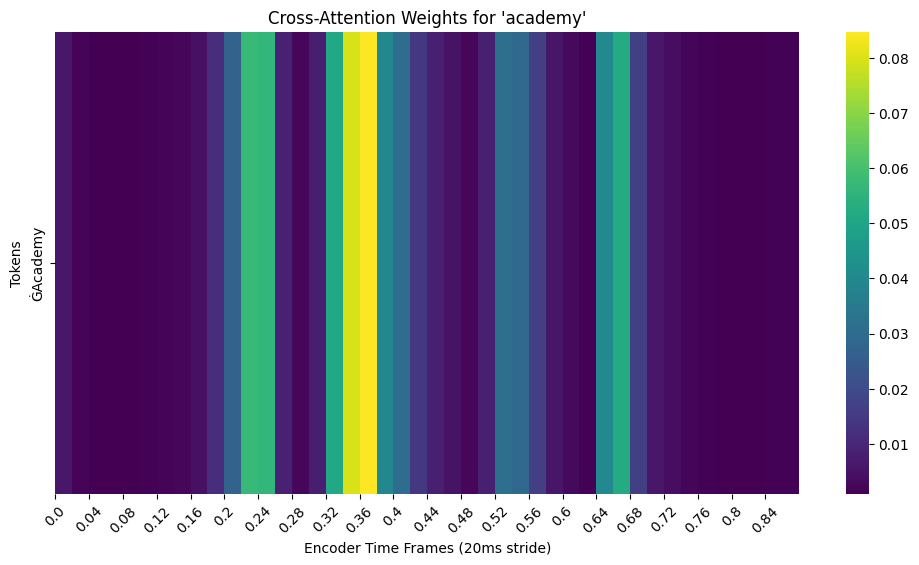

In [41]:
attentions = attentions[:, :len(trace)]
# --- Visualization 1: Cross-Attention Heatmap ---
plt.figure(figsize=(12, 6))
# We just plot the attention for the word tokens
sns.heatmap(attentions, xticklabels=50, yticklabels=tokens, cmap="viridis")
# add x-axis labels every 50 frames (1s intervals)
num_frames = attentions.shape[1]
xticks = np.arange(0, num_frames, 2)
plt.xticks(xticks, [f"{(x*0.02)}" for x in xticks], rotation=45)
plt.title(f"Cross-Attention Weights for '{target_word}'")
plt.xlabel("Encoder Time Frames (20ms stride)")
plt.ylabel("Tokens")
plt.show()


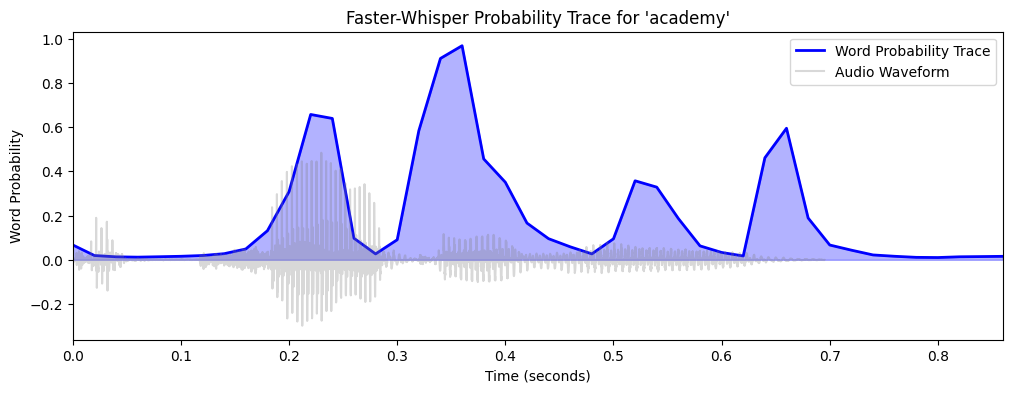

Trace data points: 44
Sampling Step: 0.0200s


In [47]:
# --- Visualization 2: Probability Trace ---
import torchaudio

# Load waveform again for visualization (optional)
# Using torchaudio or soundfile
if os.path.exists(wav_path):
    waveform, sr = torchaudio.load(wav_path)
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
        waveform = resampler(waveform)

    # Plot trace vs time
    time_step = 1.0 / sampling_rate
    time_axis = np.arange(len(trace)) * time_step
    
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, trace, label="Word Probability Trace", color='blue', linewidth=2)
    plt.fill_between(time_axis, trace, alpha=0.3, color='blue')

    # Overlay waveform normalized
    wave_norm = waveform.numpy().flatten()
    wave_norm = wave_norm / np.max(np.abs(wave_norm)) * np.max(trace) * 0.5
    wave_time = np.linspace(0, len(wave_norm)/16000, len(wave_norm))
    
    # Clip trace plot range to waveform length generally
    plt.xlim(0, max(time_axis[-1], wave_time[-1]))
    
    plt.plot(wave_time, wave_norm, color='gray', alpha=0.3, label="Audio Waveform")

    plt.title(f"Faster-Whisper Probability Trace for '{target_word}'")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Word Probability")
    plt.legend()
    plt.show()
else:
    print("Cannot visualize waveform; file not found.")

print(f"Trace data points: {len(trace)}")
print(f"Sampling Step: {time_step:.4f}s")